# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

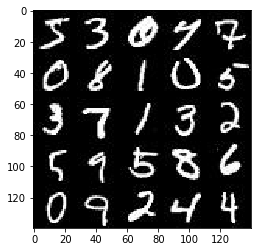

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

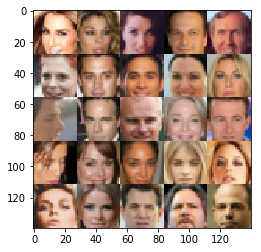

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0


/Users/ravir/miniconda2/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(dtype=tf.float32, shape=(None, z_dim), name='input_z')
    learn_rate = tf.placeholder(dtype=tf.float32,shape=())
    return input_real, input_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """   
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.2
        # Input is 28x28x3
        x1 = tf.layers.conv2d(images,64, kernel_size=5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        relu1 = tf.maximum(x1 * alpha, x1)
       
        # 14x14x64        
        x2 = tf.layers.conv2d(x1,128, kernel_size=5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(bn2 * alpha, bn2)
        
        # 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, kernel_size=5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(bn3 * alpha, bn3)

        # 4x4x256
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        
        alpha = 0.2
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*256)
        
        x1 = tf.reshape(x1, (-1, 4, 4, 256))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        # 4x4x256
        
        x2 = tf.layers.conv2d_transpose(relu1, 128, kernel_size=4, strides=1, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='valid')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d_transpose(relu2, 64, kernel_size=5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 14x14x64
        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, padding='same')
        
        # 28x28xout_channel_dim
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
   
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    batch = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch += 1
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if batch % 100 == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
                
                if batch % 10 == 0:                    
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5991... Generator Loss: 1.8800
Epoch 1/2... Discriminator Loss: 0.4628... Generator Loss: 2.5314
Epoch 1/2... Discriminator Loss: 0.5285... Generator Loss: 2.0685
Epoch 1/2... Discriminator Loss: 0.4080... Generator Loss: 3.0394
Epoch 1/2... Discriminator Loss: 0.3559... Generator Loss: 4.1050
Epoch 1/2... Discriminator Loss: 0.4110... Generator Loss: 2.7374
Epoch 1/2... Discriminator Loss: 0.3836... Generator Loss: 3.1217
Epoch 1/2... Discriminator Loss: 0.3632... Generator Loss: 3.6038
Epoch 1/2... Discriminator Loss: 0.3625... Generator Loss: 3.6563


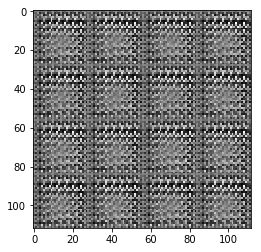

Epoch 1/2... Discriminator Loss: 0.3717... Generator Loss: 3.3460
Epoch 1/2... Discriminator Loss: 0.3666... Generator Loss: 3.3951
Epoch 1/2... Discriminator Loss: 0.3498... Generator Loss: 4.4143
Epoch 1/2... Discriminator Loss: 0.3668... Generator Loss: 3.4549
Epoch 1/2... Discriminator Loss: 0.3533... Generator Loss: 4.1491
Epoch 1/2... Discriminator Loss: 2.3207... Generator Loss: 0.2630
Epoch 1/2... Discriminator Loss: 0.5100... Generator Loss: 3.2818
Epoch 1/2... Discriminator Loss: 0.4653... Generator Loss: 2.8334
Epoch 1/2... Discriminator Loss: 0.4762... Generator Loss: 2.2310
Epoch 1/2... Discriminator Loss: 1.4188... Generator Loss: 0.4590


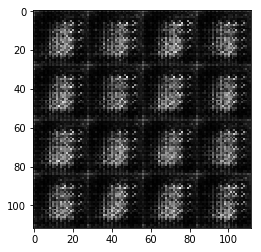

Epoch 1/2... Discriminator Loss: 1.8218... Generator Loss: 7.6800
Epoch 1/2... Discriminator Loss: 0.7518... Generator Loss: 1.2239
Epoch 1/2... Discriminator Loss: 0.5165... Generator Loss: 4.3605
Epoch 1/2... Discriminator Loss: 0.7127... Generator Loss: 1.7822
Epoch 1/2... Discriminator Loss: 0.4759... Generator Loss: 2.7841
Epoch 1/2... Discriminator Loss: 0.5180... Generator Loss: 2.0176
Epoch 1/2... Discriminator Loss: 0.6632... Generator Loss: 1.5932
Epoch 1/2... Discriminator Loss: 0.4195... Generator Loss: 3.0266
Epoch 1/2... Discriminator Loss: 0.4691... Generator Loss: 2.5393
Epoch 1/2... Discriminator Loss: 0.5020... Generator Loss: 2.5136


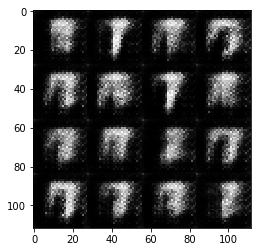

Epoch 1/2... Discriminator Loss: 0.5903... Generator Loss: 2.2900
Epoch 1/2... Discriminator Loss: 0.6753... Generator Loss: 1.9710
Epoch 1/2... Discriminator Loss: 0.6744... Generator Loss: 1.5509
Epoch 1/2... Discriminator Loss: 0.6127... Generator Loss: 1.8691
Epoch 1/2... Discriminator Loss: 0.5998... Generator Loss: 2.0890
Epoch 1/2... Discriminator Loss: 0.5479... Generator Loss: 2.3422
Epoch 1/2... Discriminator Loss: 0.6546... Generator Loss: 1.7960
Epoch 1/2... Discriminator Loss: 0.7718... Generator Loss: 1.3572
Epoch 1/2... Discriminator Loss: 0.5449... Generator Loss: 2.0107
Epoch 1/2... Discriminator Loss: 0.5770... Generator Loss: 2.2442


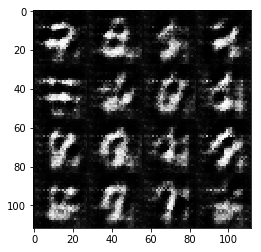

Epoch 1/2... Discriminator Loss: 0.7915... Generator Loss: 1.9730
Epoch 1/2... Discriminator Loss: 0.6918... Generator Loss: 1.8758
Epoch 1/2... Discriminator Loss: 0.7888... Generator Loss: 1.4544
Epoch 1/2... Discriminator Loss: 0.7876... Generator Loss: 2.0764
Epoch 1/2... Discriminator Loss: 0.6926... Generator Loss: 1.8952
Epoch 1/2... Discriminator Loss: 0.8613... Generator Loss: 1.4982
Epoch 1/2... Discriminator Loss: 0.8388... Generator Loss: 1.6168
Epoch 1/2... Discriminator Loss: 1.0390... Generator Loss: 0.9704
Epoch 1/2... Discriminator Loss: 0.9025... Generator Loss: 1.6795
Epoch 1/2... Discriminator Loss: 0.8452... Generator Loss: 1.7150


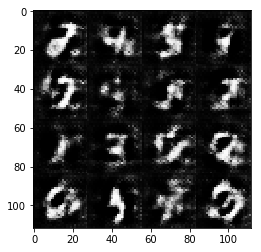

Epoch 1/2... Discriminator Loss: 0.7618... Generator Loss: 1.5410
Epoch 1/2... Discriminator Loss: 0.9092... Generator Loss: 1.4216
Epoch 1/2... Discriminator Loss: 1.2736... Generator Loss: 0.6344
Epoch 1/2... Discriminator Loss: 0.8921... Generator Loss: 2.2241
Epoch 1/2... Discriminator Loss: 1.0527... Generator Loss: 0.9615
Epoch 1/2... Discriminator Loss: 0.7556... Generator Loss: 1.4808
Epoch 1/2... Discriminator Loss: 1.2020... Generator Loss: 0.7152
Epoch 1/2... Discriminator Loss: 0.9251... Generator Loss: 1.3227
Epoch 1/2... Discriminator Loss: 0.8129... Generator Loss: 1.6802
Epoch 1/2... Discriminator Loss: 1.0428... Generator Loss: 2.0176


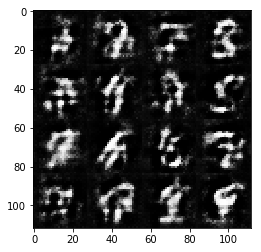

Epoch 1/2... Discriminator Loss: 0.9431... Generator Loss: 1.2197
Epoch 1/2... Discriminator Loss: 1.0034... Generator Loss: 1.3619
Epoch 1/2... Discriminator Loss: 0.9049... Generator Loss: 1.1622
Epoch 1/2... Discriminator Loss: 0.8873... Generator Loss: 1.7431
Epoch 1/2... Discriminator Loss: 0.8893... Generator Loss: 1.9400
Epoch 1/2... Discriminator Loss: 1.1665... Generator Loss: 0.7648
Epoch 1/2... Discriminator Loss: 1.1389... Generator Loss: 1.2373
Epoch 1/2... Discriminator Loss: 0.9244... Generator Loss: 1.3400
Epoch 1/2... Discriminator Loss: 1.1502... Generator Loss: 0.9984
Epoch 1/2... Discriminator Loss: 0.9926... Generator Loss: 1.2865


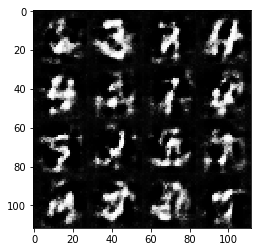

Epoch 1/2... Discriminator Loss: 1.1243... Generator Loss: 1.3966
Epoch 1/2... Discriminator Loss: 1.1118... Generator Loss: 1.1034
Epoch 1/2... Discriminator Loss: 1.1542... Generator Loss: 1.0803
Epoch 1/2... Discriminator Loss: 1.1273... Generator Loss: 1.0788
Epoch 1/2... Discriminator Loss: 1.3233... Generator Loss: 0.9229
Epoch 1/2... Discriminator Loss: 1.2229... Generator Loss: 0.8377
Epoch 1/2... Discriminator Loss: 1.1219... Generator Loss: 0.9733
Epoch 1/2... Discriminator Loss: 0.8121... Generator Loss: 1.3556
Epoch 1/2... Discriminator Loss: 1.1935... Generator Loss: 1.1204
Epoch 1/2... Discriminator Loss: 1.0429... Generator Loss: 1.5896


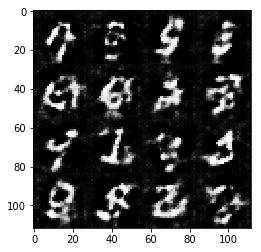

Epoch 1/2... Discriminator Loss: 1.0466... Generator Loss: 1.0439
Epoch 1/2... Discriminator Loss: 1.0215... Generator Loss: 1.5846
Epoch 1/2... Discriminator Loss: 0.9000... Generator Loss: 1.4256
Epoch 1/2... Discriminator Loss: 1.0103... Generator Loss: 1.2155
Epoch 1/2... Discriminator Loss: 0.8555... Generator Loss: 1.6738
Epoch 1/2... Discriminator Loss: 1.1164... Generator Loss: 1.5658
Epoch 1/2... Discriminator Loss: 1.0150... Generator Loss: 1.7640
Epoch 1/2... Discriminator Loss: 1.2284... Generator Loss: 0.9733
Epoch 1/2... Discriminator Loss: 1.0633... Generator Loss: 1.1552
Epoch 1/2... Discriminator Loss: 1.1396... Generator Loss: 0.9093


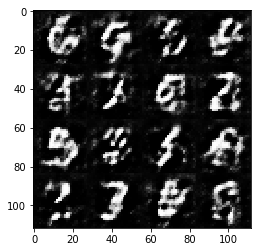

Epoch 1/2... Discriminator Loss: 1.1296... Generator Loss: 0.9525
Epoch 1/2... Discriminator Loss: 1.0746... Generator Loss: 1.0537
Epoch 1/2... Discriminator Loss: 1.0052... Generator Loss: 1.1601
Epoch 1/2... Discriminator Loss: 0.8969... Generator Loss: 1.3255
Epoch 2/2... Discriminator Loss: 0.9615... Generator Loss: 1.1515
Epoch 2/2... Discriminator Loss: 1.0623... Generator Loss: 1.1259
Epoch 2/2... Discriminator Loss: 0.8974... Generator Loss: 1.2890
Epoch 2/2... Discriminator Loss: 1.1713... Generator Loss: 1.3149
Epoch 2/2... Discriminator Loss: 1.1434... Generator Loss: 1.0702
Epoch 2/2... Discriminator Loss: 1.0675... Generator Loss: 1.0075


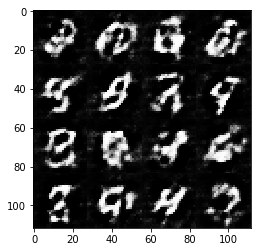

Epoch 2/2... Discriminator Loss: 1.0591... Generator Loss: 1.1826
Epoch 2/2... Discriminator Loss: 1.0043... Generator Loss: 1.2817
Epoch 2/2... Discriminator Loss: 0.8411... Generator Loss: 1.4797
Epoch 2/2... Discriminator Loss: 0.9984... Generator Loss: 1.1995
Epoch 2/2... Discriminator Loss: 1.0440... Generator Loss: 1.1062
Epoch 2/2... Discriminator Loss: 1.0023... Generator Loss: 1.6219
Epoch 2/2... Discriminator Loss: 0.9131... Generator Loss: 1.2652
Epoch 2/2... Discriminator Loss: 0.9818... Generator Loss: 1.1717
Epoch 2/2... Discriminator Loss: 1.1366... Generator Loss: 1.4606
Epoch 2/2... Discriminator Loss: 0.9998... Generator Loss: 1.3185


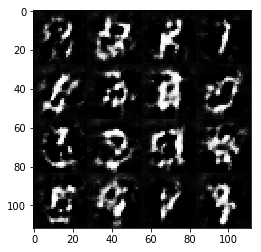

Epoch 2/2... Discriminator Loss: 1.0269... Generator Loss: 1.2817
Epoch 2/2... Discriminator Loss: 0.9554... Generator Loss: 1.5475
Epoch 2/2... Discriminator Loss: 1.0264... Generator Loss: 1.2082
Epoch 2/2... Discriminator Loss: 1.0469... Generator Loss: 1.0810
Epoch 2/2... Discriminator Loss: 0.9529... Generator Loss: 1.5412
Epoch 2/2... Discriminator Loss: 1.2191... Generator Loss: 0.7926
Epoch 2/2... Discriminator Loss: 0.9555... Generator Loss: 1.5678
Epoch 2/2... Discriminator Loss: 1.0607... Generator Loss: 0.9834
Epoch 2/2... Discriminator Loss: 0.9633... Generator Loss: 1.1434
Epoch 2/2... Discriminator Loss: 0.9255... Generator Loss: 1.4949


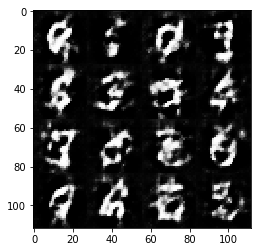

Epoch 2/2... Discriminator Loss: 0.9648... Generator Loss: 1.2321
Epoch 2/2... Discriminator Loss: 0.9002... Generator Loss: 1.4299
Epoch 2/2... Discriminator Loss: 1.0359... Generator Loss: 1.2677
Epoch 2/2... Discriminator Loss: 0.9604... Generator Loss: 1.1396
Epoch 2/2... Discriminator Loss: 1.0218... Generator Loss: 1.3744
Epoch 2/2... Discriminator Loss: 0.9582... Generator Loss: 1.5824
Epoch 2/2... Discriminator Loss: 1.0031... Generator Loss: 1.4595
Epoch 2/2... Discriminator Loss: 1.0504... Generator Loss: 1.0476
Epoch 2/2... Discriminator Loss: 0.9833... Generator Loss: 1.3962
Epoch 2/2... Discriminator Loss: 1.0407... Generator Loss: 1.5690


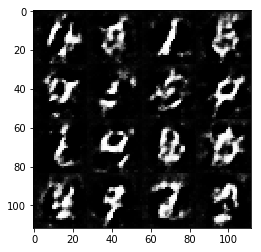

Epoch 2/2... Discriminator Loss: 1.0674... Generator Loss: 0.9342
Epoch 2/2... Discriminator Loss: 0.9894... Generator Loss: 1.1841
Epoch 2/2... Discriminator Loss: 1.0826... Generator Loss: 1.3815
Epoch 2/2... Discriminator Loss: 0.9373... Generator Loss: 1.3084
Epoch 2/2... Discriminator Loss: 1.0094... Generator Loss: 1.6222
Epoch 2/2... Discriminator Loss: 0.9559... Generator Loss: 1.4357
Epoch 2/2... Discriminator Loss: 0.9436... Generator Loss: 1.1072
Epoch 2/2... Discriminator Loss: 0.9420... Generator Loss: 1.5805
Epoch 2/2... Discriminator Loss: 1.0028... Generator Loss: 1.4529
Epoch 2/2... Discriminator Loss: 0.9289... Generator Loss: 1.3812


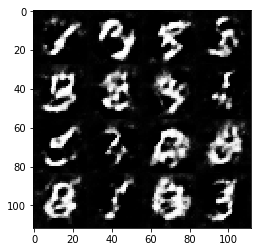

Epoch 2/2... Discriminator Loss: 0.9520... Generator Loss: 1.2042
Epoch 2/2... Discriminator Loss: 1.0009... Generator Loss: 1.1866
Epoch 2/2... Discriminator Loss: 1.1273... Generator Loss: 0.9328
Epoch 2/2... Discriminator Loss: 0.9174... Generator Loss: 1.4732
Epoch 2/2... Discriminator Loss: 1.0557... Generator Loss: 1.7642
Epoch 2/2... Discriminator Loss: 0.9516... Generator Loss: 1.4097
Epoch 2/2... Discriminator Loss: 0.9736... Generator Loss: 1.2640
Epoch 2/2... Discriminator Loss: 0.9535... Generator Loss: 1.1909
Epoch 2/2... Discriminator Loss: 0.9572... Generator Loss: 1.3972
Epoch 2/2... Discriminator Loss: 0.8895... Generator Loss: 1.2880


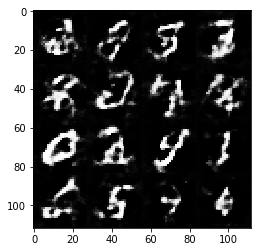

Epoch 2/2... Discriminator Loss: 0.9045... Generator Loss: 1.1246
Epoch 2/2... Discriminator Loss: 1.0322... Generator Loss: 0.9251
Epoch 2/2... Discriminator Loss: 0.9248... Generator Loss: 1.2542
Epoch 2/2... Discriminator Loss: 0.8291... Generator Loss: 1.2900
Epoch 2/2... Discriminator Loss: 1.0037... Generator Loss: 1.0461
Epoch 2/2... Discriminator Loss: 0.9235... Generator Loss: 1.2848
Epoch 2/2... Discriminator Loss: 0.9411... Generator Loss: 1.1810
Epoch 2/2... Discriminator Loss: 1.0095... Generator Loss: 1.1155
Epoch 2/2... Discriminator Loss: 0.9802... Generator Loss: 1.2372
Epoch 2/2... Discriminator Loss: 1.0158... Generator Loss: 1.1158


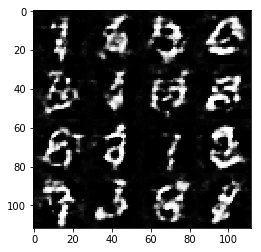

Epoch 2/2... Discriminator Loss: 0.9436... Generator Loss: 1.4022
Epoch 2/2... Discriminator Loss: 1.0806... Generator Loss: 1.0815
Epoch 2/2... Discriminator Loss: 0.9152... Generator Loss: 1.3337
Epoch 2/2... Discriminator Loss: 1.0135... Generator Loss: 1.1591
Epoch 2/2... Discriminator Loss: 0.9533... Generator Loss: 1.1792
Epoch 2/2... Discriminator Loss: 0.9374... Generator Loss: 1.1508
Epoch 2/2... Discriminator Loss: 1.0335... Generator Loss: 1.5529
Epoch 2/2... Discriminator Loss: 0.8853... Generator Loss: 1.3201
Epoch 2/2... Discriminator Loss: 0.9939... Generator Loss: 1.4275
Epoch 2/2... Discriminator Loss: 0.9659... Generator Loss: 1.4799


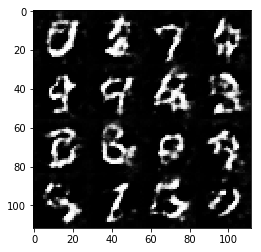

Epoch 2/2... Discriminator Loss: 1.0120... Generator Loss: 1.0223
Epoch 2/2... Discriminator Loss: 0.9666... Generator Loss: 1.3132
Epoch 2/2... Discriminator Loss: 1.0004... Generator Loss: 1.0071
Epoch 2/2... Discriminator Loss: 1.0142... Generator Loss: 1.0988
Epoch 2/2... Discriminator Loss: 1.0666... Generator Loss: 1.3766
Epoch 2/2... Discriminator Loss: 1.0827... Generator Loss: 1.6582
Epoch 2/2... Discriminator Loss: 0.9990... Generator Loss: 1.4657
Epoch 2/2... Discriminator Loss: 0.9269... Generator Loss: 1.3002
Epoch 2/2... Discriminator Loss: 1.0798... Generator Loss: 0.8857
Epoch 2/2... Discriminator Loss: 0.8516... Generator Loss: 1.6927


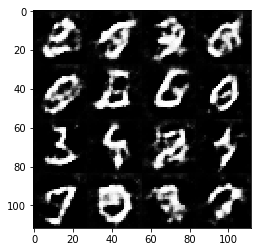

Epoch 2/2... Discriminator Loss: 1.0355... Generator Loss: 1.2469
Epoch 2/2... Discriminator Loss: 1.1062... Generator Loss: 1.1519
Epoch 2/2... Discriminator Loss: 0.9126... Generator Loss: 1.2037
Epoch 2/2... Discriminator Loss: 0.9565... Generator Loss: 1.2595
Epoch 2/2... Discriminator Loss: 1.0124... Generator Loss: 1.3966
Epoch 2/2... Discriminator Loss: 0.9439... Generator Loss: 1.3602
Epoch 2/2... Discriminator Loss: 0.9949... Generator Loss: 1.1643
Epoch 2/2... Discriminator Loss: 0.8660... Generator Loss: 1.4230


In [12]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8260... Generator Loss: 1.1080
Epoch 1/1... Discriminator Loss: 0.8607... Generator Loss: 1.0398
Epoch 1/1... Discriminator Loss: 0.7475... Generator Loss: 1.4412
Epoch 1/1... Discriminator Loss: 0.5683... Generator Loss: 1.9463
Epoch 1/1... Discriminator Loss: 0.5501... Generator Loss: 2.1267
Epoch 1/1... Discriminator Loss: 0.5035... Generator Loss: 2.1479
Epoch 1/1... Discriminator Loss: 0.4585... Generator Loss: 2.6009
Epoch 1/1... Discriminator Loss: 0.4669... Generator Loss: 2.3475
Epoch 1/1... Discriminator Loss: 0.4358... Generator Loss: 2.6193


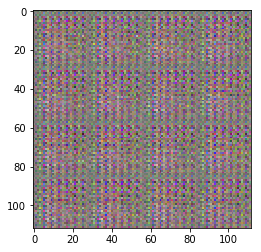

Epoch 1/1... Discriminator Loss: 0.4751... Generator Loss: 2.5421
Epoch 1/1... Discriminator Loss: 0.4191... Generator Loss: 2.9557
Epoch 1/1... Discriminator Loss: 0.4534... Generator Loss: 2.5823
Epoch 1/1... Discriminator Loss: 0.4094... Generator Loss: 3.0182
Epoch 1/1... Discriminator Loss: 0.4192... Generator Loss: 2.9209
Epoch 1/1... Discriminator Loss: 0.4032... Generator Loss: 3.1688
Epoch 1/1... Discriminator Loss: 0.3925... Generator Loss: 3.1966
Epoch 1/1... Discriminator Loss: 0.4122... Generator Loss: 2.8986
Epoch 1/1... Discriminator Loss: 0.3803... Generator Loss: 3.4383
Epoch 1/1... Discriminator Loss: 0.3788... Generator Loss: 3.3416


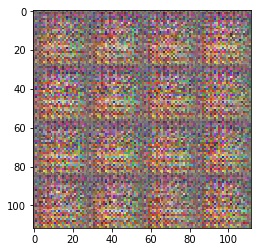

Epoch 1/1... Discriminator Loss: 0.3788... Generator Loss: 3.3342
Epoch 1/1... Discriminator Loss: 0.3886... Generator Loss: 3.2564
Epoch 1/1... Discriminator Loss: 0.3777... Generator Loss: 3.5730
Epoch 1/1... Discriminator Loss: 0.3990... Generator Loss: 3.0974
Epoch 1/1... Discriminator Loss: 0.3757... Generator Loss: 3.6891
Epoch 1/1... Discriminator Loss: 0.3809... Generator Loss: 3.4190
Epoch 1/1... Discriminator Loss: 0.3987... Generator Loss: 3.0673
Epoch 1/1... Discriminator Loss: 0.4240... Generator Loss: 3.3837
Epoch 1/1... Discriminator Loss: 0.4942... Generator Loss: 2.0982
Epoch 1/1... Discriminator Loss: 0.4179... Generator Loss: 3.4719


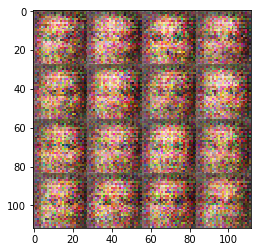

Epoch 1/1... Discriminator Loss: 0.4286... Generator Loss: 3.2334
Epoch 1/1... Discriminator Loss: 0.4493... Generator Loss: 2.9011
Epoch 1/1... Discriminator Loss: 0.5016... Generator Loss: 2.3630
Epoch 1/1... Discriminator Loss: 0.5532... Generator Loss: 1.8783
Epoch 1/1... Discriminator Loss: 0.6307... Generator Loss: 2.7289
Epoch 1/1... Discriminator Loss: 0.5696... Generator Loss: 2.1173
Epoch 1/1... Discriminator Loss: 0.6346... Generator Loss: 2.2291
Epoch 1/1... Discriminator Loss: 0.5538... Generator Loss: 2.1809
Epoch 1/1... Discriminator Loss: 0.7795... Generator Loss: 1.1323
Epoch 1/1... Discriminator Loss: 0.5963... Generator Loss: 1.7951


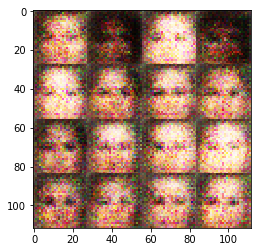

Epoch 1/1... Discriminator Loss: 0.6120... Generator Loss: 2.8844
Epoch 1/1... Discriminator Loss: 0.5565... Generator Loss: 2.3003
Epoch 1/1... Discriminator Loss: 0.5791... Generator Loss: 2.4088
Epoch 1/1... Discriminator Loss: 0.5245... Generator Loss: 2.1935
Epoch 1/1... Discriminator Loss: 0.5929... Generator Loss: 1.8967
Epoch 1/1... Discriminator Loss: 0.5236... Generator Loss: 2.2838
Epoch 1/1... Discriminator Loss: 0.5621... Generator Loss: 1.9455
Epoch 1/1... Discriminator Loss: 0.6128... Generator Loss: 2.0138
Epoch 1/1... Discriminator Loss: 0.5639... Generator Loss: 1.7754
Epoch 1/1... Discriminator Loss: 0.4993... Generator Loss: 2.2722


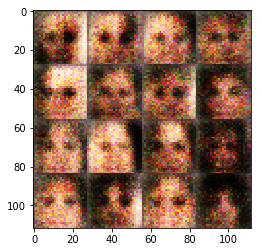

Epoch 1/1... Discriminator Loss: 0.6685... Generator Loss: 1.5568
Epoch 1/1... Discriminator Loss: 0.5118... Generator Loss: 2.4981
Epoch 1/1... Discriminator Loss: 0.5518... Generator Loss: 2.0622
Epoch 1/1... Discriminator Loss: 0.5295... Generator Loss: 2.4295
Epoch 1/1... Discriminator Loss: 0.5287... Generator Loss: 2.2454
Epoch 1/1... Discriminator Loss: 0.5203... Generator Loss: 2.5311
Epoch 1/1... Discriminator Loss: 0.5320... Generator Loss: 2.3011
Epoch 1/1... Discriminator Loss: 0.5810... Generator Loss: 2.3165
Epoch 1/1... Discriminator Loss: 0.6200... Generator Loss: 1.6625
Epoch 1/1... Discriminator Loss: 0.5855... Generator Loss: 1.7766


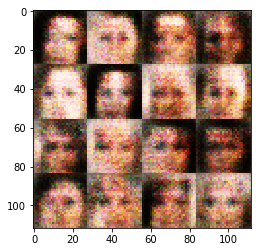

Epoch 1/1... Discriminator Loss: 0.5905... Generator Loss: 2.3071
Epoch 1/1... Discriminator Loss: 0.6634... Generator Loss: 2.0324
Epoch 1/1... Discriminator Loss: 0.6811... Generator Loss: 1.5217
Epoch 1/1... Discriminator Loss: 0.7452... Generator Loss: 1.5707
Epoch 1/1... Discriminator Loss: 0.8061... Generator Loss: 1.2592
Epoch 1/1... Discriminator Loss: 0.7573... Generator Loss: 1.4656
Epoch 1/1... Discriminator Loss: 0.6799... Generator Loss: 1.9520
Epoch 1/1... Discriminator Loss: 0.6218... Generator Loss: 2.0190
Epoch 1/1... Discriminator Loss: 0.8998... Generator Loss: 1.0249
Epoch 1/1... Discriminator Loss: 0.7018... Generator Loss: 1.8526


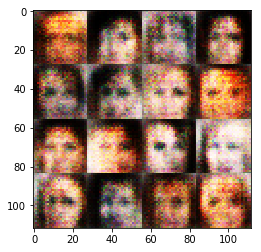

Epoch 1/1... Discriminator Loss: 0.7190... Generator Loss: 1.5672
Epoch 1/1... Discriminator Loss: 0.7888... Generator Loss: 1.9519
Epoch 1/1... Discriminator Loss: 0.7448... Generator Loss: 2.0888
Epoch 1/1... Discriminator Loss: 0.6729... Generator Loss: 1.7705
Epoch 1/1... Discriminator Loss: 0.6219... Generator Loss: 1.7724
Epoch 1/1... Discriminator Loss: 0.7171... Generator Loss: 1.3325
Epoch 1/1... Discriminator Loss: 0.6878... Generator Loss: 1.4873
Epoch 1/1... Discriminator Loss: 0.6931... Generator Loss: 2.1019
Epoch 1/1... Discriminator Loss: 0.7293... Generator Loss: 1.7391
Epoch 1/1... Discriminator Loss: 0.6805... Generator Loss: 1.7016


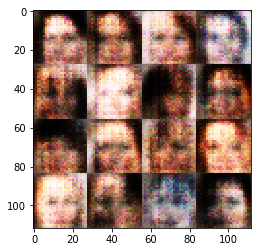

Epoch 1/1... Discriminator Loss: 0.6996... Generator Loss: 1.4703
Epoch 1/1... Discriminator Loss: 0.6962... Generator Loss: 1.4636
Epoch 1/1... Discriminator Loss: 0.6840... Generator Loss: 1.5766
Epoch 1/1... Discriminator Loss: 0.6891... Generator Loss: 1.6952
Epoch 1/1... Discriminator Loss: 0.6213... Generator Loss: 2.0843
Epoch 1/1... Discriminator Loss: 0.7060... Generator Loss: 2.0230
Epoch 1/1... Discriminator Loss: 0.7318... Generator Loss: 1.4179
Epoch 1/1... Discriminator Loss: 0.6594... Generator Loss: 2.1680
Epoch 1/1... Discriminator Loss: 0.7139... Generator Loss: 2.2299
Epoch 1/1... Discriminator Loss: 0.8200... Generator Loss: 2.5563


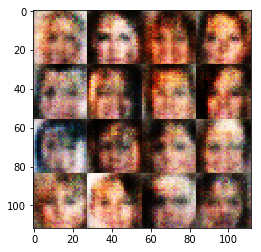

Epoch 1/1... Discriminator Loss: 0.7283... Generator Loss: 1.6445
Epoch 1/1... Discriminator Loss: 0.6498... Generator Loss: 1.9632
Epoch 1/1... Discriminator Loss: 0.7122... Generator Loss: 1.5172
Epoch 1/1... Discriminator Loss: 0.7324... Generator Loss: 1.9025
Epoch 1/1... Discriminator Loss: 0.7236... Generator Loss: 1.6834
Epoch 1/1... Discriminator Loss: 0.7471... Generator Loss: 1.5000
Epoch 1/1... Discriminator Loss: 0.7443... Generator Loss: 2.0762
Epoch 1/1... Discriminator Loss: 0.8348... Generator Loss: 1.2311
Epoch 1/1... Discriminator Loss: 0.7293... Generator Loss: 1.5667
Epoch 1/1... Discriminator Loss: 0.7486... Generator Loss: 1.7037


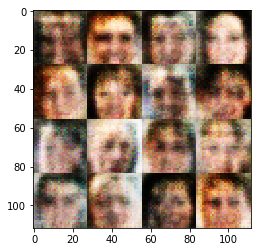

Epoch 1/1... Discriminator Loss: 0.7314... Generator Loss: 1.4128
Epoch 1/1... Discriminator Loss: 0.8104... Generator Loss: 1.3560
Epoch 1/1... Discriminator Loss: 0.7434... Generator Loss: 1.4271
Epoch 1/1... Discriminator Loss: 0.8828... Generator Loss: 0.9955
Epoch 1/1... Discriminator Loss: 0.6393... Generator Loss: 1.6674
Epoch 1/1... Discriminator Loss: 0.6036... Generator Loss: 1.9361
Epoch 1/1... Discriminator Loss: 0.6468... Generator Loss: 1.6404
Epoch 1/1... Discriminator Loss: 0.5982... Generator Loss: 1.7441
Epoch 1/1... Discriminator Loss: 0.5584... Generator Loss: 1.9245
Epoch 1/1... Discriminator Loss: 0.6238... Generator Loss: 1.9373


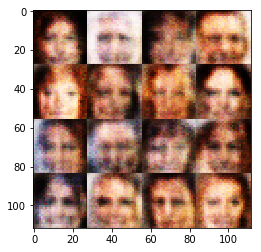

Epoch 1/1... Discriminator Loss: 0.6523... Generator Loss: 2.4990
Epoch 1/1... Discriminator Loss: 0.6735... Generator Loss: 1.8910
Epoch 1/1... Discriminator Loss: 0.7405... Generator Loss: 1.6235
Epoch 1/1... Discriminator Loss: 0.5948... Generator Loss: 1.8890
Epoch 1/1... Discriminator Loss: 0.6165... Generator Loss: 1.9316
Epoch 1/1... Discriminator Loss: 0.6764... Generator Loss: 1.5968
Epoch 1/1... Discriminator Loss: 0.8251... Generator Loss: 1.1249
Epoch 1/1... Discriminator Loss: 0.4925... Generator Loss: 2.5141
Epoch 1/1... Discriminator Loss: 0.4899... Generator Loss: 2.3510
Epoch 1/1... Discriminator Loss: 0.6097... Generator Loss: 1.6732


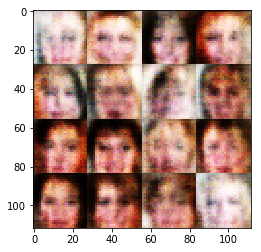

Epoch 1/1... Discriminator Loss: 0.6049... Generator Loss: 2.0580
Epoch 1/1... Discriminator Loss: 0.6270... Generator Loss: 1.5927
Epoch 1/1... Discriminator Loss: 0.4882... Generator Loss: 2.5112
Epoch 1/1... Discriminator Loss: 0.5599... Generator Loss: 2.2374
Epoch 1/1... Discriminator Loss: 0.5122... Generator Loss: 2.3932
Epoch 1/1... Discriminator Loss: 0.5630... Generator Loss: 2.1489
Epoch 1/1... Discriminator Loss: 0.6399... Generator Loss: 2.1751
Epoch 1/1... Discriminator Loss: 0.5055... Generator Loss: 2.2603
Epoch 1/1... Discriminator Loss: 0.4776... Generator Loss: 2.5099
Epoch 1/1... Discriminator Loss: 0.5636... Generator Loss: 2.6716


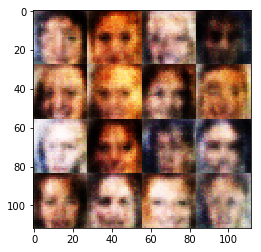

Epoch 1/1... Discriminator Loss: 0.5455... Generator Loss: 2.7048
Epoch 1/1... Discriminator Loss: 0.5328... Generator Loss: 2.3606
Epoch 1/1... Discriminator Loss: 0.4816... Generator Loss: 2.7153
Epoch 1/1... Discriminator Loss: 0.6275... Generator Loss: 2.2803
Epoch 1/1... Discriminator Loss: 0.4428... Generator Loss: 3.7432
Epoch 1/1... Discriminator Loss: 0.5948... Generator Loss: 1.8471
Epoch 1/1... Discriminator Loss: 0.6539... Generator Loss: 3.0518
Epoch 1/1... Discriminator Loss: 0.5472... Generator Loss: 3.0300
Epoch 1/1... Discriminator Loss: 0.5079... Generator Loss: 2.4109
Epoch 1/1... Discriminator Loss: 0.5595... Generator Loss: 2.5944


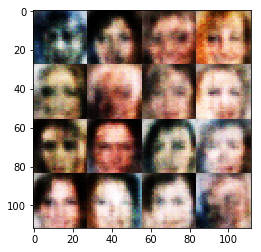

Epoch 1/1... Discriminator Loss: 0.3907... Generator Loss: 4.4138
Epoch 1/1... Discriminator Loss: 0.7227... Generator Loss: 1.3094
Epoch 1/1... Discriminator Loss: 0.5665... Generator Loss: 1.8895
Epoch 1/1... Discriminator Loss: 0.4927... Generator Loss: 2.5163
Epoch 1/1... Discriminator Loss: 0.5234... Generator Loss: 2.1797
Epoch 1/1... Discriminator Loss: 0.7841... Generator Loss: 3.4421
Epoch 1/1... Discriminator Loss: 0.5251... Generator Loss: 2.0517
Epoch 1/1... Discriminator Loss: 0.5121... Generator Loss: 2.1726
Epoch 1/1... Discriminator Loss: 0.5508... Generator Loss: 1.9216
Epoch 1/1... Discriminator Loss: 0.6121... Generator Loss: 1.7004


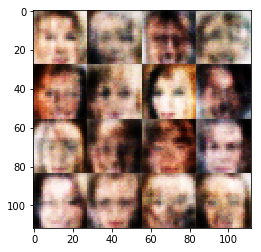

Epoch 1/1... Discriminator Loss: 0.4788... Generator Loss: 2.9589
Epoch 1/1... Discriminator Loss: 0.4100... Generator Loss: 4.0754
Epoch 1/1... Discriminator Loss: 0.5720... Generator Loss: 5.7278
Epoch 1/1... Discriminator Loss: 0.6442... Generator Loss: 1.5950
Epoch 1/1... Discriminator Loss: 0.5448... Generator Loss: 2.2773
Epoch 1/1... Discriminator Loss: 0.5497... Generator Loss: 1.9413
Epoch 1/1... Discriminator Loss: 0.4162... Generator Loss: 2.8111
Epoch 1/1... Discriminator Loss: 0.5028... Generator Loss: 2.9119
Epoch 1/1... Discriminator Loss: 0.5001... Generator Loss: 4.3474
Epoch 1/1... Discriminator Loss: 0.5776... Generator Loss: 3.3343


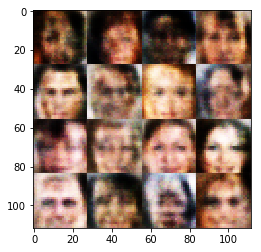

Epoch 1/1... Discriminator Loss: 0.4285... Generator Loss: 3.9417
Epoch 1/1... Discriminator Loss: 0.4210... Generator Loss: 3.4232
Epoch 1/1... Discriminator Loss: 0.3566... Generator Loss: 5.2736
Epoch 1/1... Discriminator Loss: 0.4184... Generator Loss: 3.3908
Epoch 1/1... Discriminator Loss: 0.5048... Generator Loss: 2.0613
Epoch 1/1... Discriminator Loss: 0.4061... Generator Loss: 3.3669
Epoch 1/1... Discriminator Loss: 0.4540... Generator Loss: 2.7935
Epoch 1/1... Discriminator Loss: 0.5476... Generator Loss: 1.9413
Epoch 1/1... Discriminator Loss: 0.4625... Generator Loss: 2.3851
Epoch 1/1... Discriminator Loss: 0.4640... Generator Loss: 2.7927


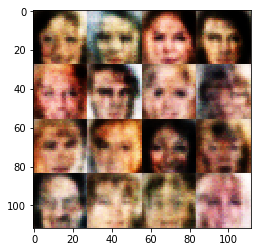

Epoch 1/1... Discriminator Loss: 0.5979... Generator Loss: 1.6741
Epoch 1/1... Discriminator Loss: 0.4980... Generator Loss: 2.2306
Epoch 1/1... Discriminator Loss: 0.6423... Generator Loss: 1.5866
Epoch 1/1... Discriminator Loss: 0.4906... Generator Loss: 2.2851
Epoch 1/1... Discriminator Loss: 0.3831... Generator Loss: 4.1195
Epoch 1/1... Discriminator Loss: 0.4086... Generator Loss: 3.1222
Epoch 1/1... Discriminator Loss: 0.3736... Generator Loss: 4.0562
Epoch 1/1... Discriminator Loss: 0.3720... Generator Loss: 5.1725
Epoch 1/1... Discriminator Loss: 0.3810... Generator Loss: 3.9356
Epoch 1/1... Discriminator Loss: 0.4219... Generator Loss: 3.0070


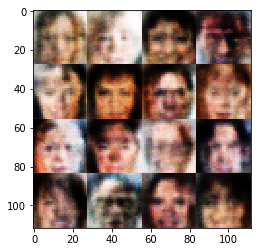

Epoch 1/1... Discriminator Loss: 0.4005... Generator Loss: 4.1373
Epoch 1/1... Discriminator Loss: 0.3755... Generator Loss: 4.7976
Epoch 1/1... Discriminator Loss: 0.3779... Generator Loss: 4.1701
Epoch 1/1... Discriminator Loss: 0.3897... Generator Loss: 4.1219
Epoch 1/1... Discriminator Loss: 0.4172... Generator Loss: 3.3068
Epoch 1/1... Discriminator Loss: 0.4121... Generator Loss: 3.5248
Epoch 1/1... Discriminator Loss: 0.3903... Generator Loss: 3.5623
Epoch 1/1... Discriminator Loss: 0.3726... Generator Loss: 3.8094
Epoch 1/1... Discriminator Loss: 0.4187... Generator Loss: 3.3781
Epoch 1/1... Discriminator Loss: 0.3997... Generator Loss: 3.7107


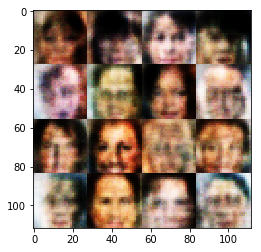

Epoch 1/1... Discriminator Loss: 0.4432... Generator Loss: 2.7604
Epoch 1/1... Discriminator Loss: 0.4158... Generator Loss: 3.2045
Epoch 1/1... Discriminator Loss: 0.6254... Generator Loss: 1.5591
Epoch 1/1... Discriminator Loss: 0.3997... Generator Loss: 3.7160
Epoch 1/1... Discriminator Loss: 0.4454... Generator Loss: 3.7649
Epoch 1/1... Discriminator Loss: 0.3812... Generator Loss: 4.5609
Epoch 1/1... Discriminator Loss: 0.4443... Generator Loss: 3.7622
Epoch 1/1... Discriminator Loss: 0.4194... Generator Loss: 2.9067
Epoch 1/1... Discriminator Loss: 0.4038... Generator Loss: 3.8464
Epoch 1/1... Discriminator Loss: 0.3810... Generator Loss: 4.0472


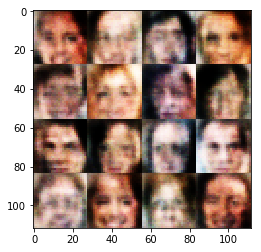

Epoch 1/1... Discriminator Loss: 0.3839... Generator Loss: 3.9986
Epoch 1/1... Discriminator Loss: 0.4739... Generator Loss: 5.2950
Epoch 1/1... Discriminator Loss: 0.3523... Generator Loss: 5.4829
Epoch 1/1... Discriminator Loss: 0.3976... Generator Loss: 4.9361
Epoch 1/1... Discriminator Loss: 0.3634... Generator Loss: 4.9467
Epoch 1/1... Discriminator Loss: 0.4884... Generator Loss: 2.3143
Epoch 1/1... Discriminator Loss: 0.5008... Generator Loss: 2.2976
Epoch 1/1... Discriminator Loss: 0.7229... Generator Loss: 1.2786
Epoch 1/1... Discriminator Loss: 0.4547... Generator Loss: 2.5568
Epoch 1/1... Discriminator Loss: 0.4527... Generator Loss: 2.4546


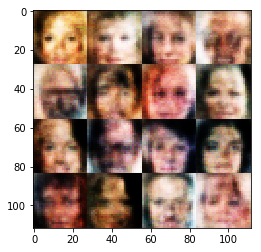

Epoch 1/1... Discriminator Loss: 0.4542... Generator Loss: 2.4454
Epoch 1/1... Discriminator Loss: 0.4711... Generator Loss: 2.5956
Epoch 1/1... Discriminator Loss: 0.4153... Generator Loss: 2.9568
Epoch 1/1... Discriminator Loss: 0.3895... Generator Loss: 4.4044
Epoch 1/1... Discriminator Loss: 0.4207... Generator Loss: 3.1372
Epoch 1/1... Discriminator Loss: 0.5664... Generator Loss: 1.7722
Epoch 1/1... Discriminator Loss: 0.4047... Generator Loss: 3.8808
Epoch 1/1... Discriminator Loss: 0.3574... Generator Loss: 6.1956
Epoch 1/1... Discriminator Loss: 0.3467... Generator Loss: 5.7451
Epoch 1/1... Discriminator Loss: 0.3912... Generator Loss: 4.1192


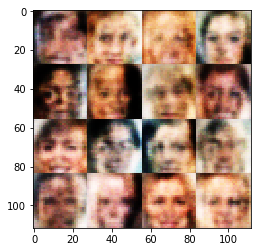

Epoch 1/1... Discriminator Loss: 0.3574... Generator Loss: 4.7728
Epoch 1/1... Discriminator Loss: 0.3758... Generator Loss: 3.9177
Epoch 1/1... Discriminator Loss: 0.5099... Generator Loss: 4.4834
Epoch 1/1... Discriminator Loss: 0.3997... Generator Loss: 3.4736
Epoch 1/1... Discriminator Loss: 0.3605... Generator Loss: 5.0615
Epoch 1/1... Discriminator Loss: 1.8593... Generator Loss: 4.5325
Epoch 1/1... Discriminator Loss: 0.6082... Generator Loss: 1.8798
Epoch 1/1... Discriminator Loss: 0.5591... Generator Loss: 1.8676
Epoch 1/1... Discriminator Loss: 0.3976... Generator Loss: 3.5992
Epoch 1/1... Discriminator Loss: 0.3867... Generator Loss: 3.9193


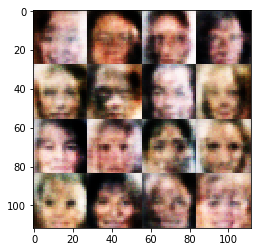

Epoch 1/1... Discriminator Loss: 0.4193... Generator Loss: 2.9701
Epoch 1/1... Discriminator Loss: 0.7708... Generator Loss: 1.1978
Epoch 1/1... Discriminator Loss: 0.3532... Generator Loss: 5.5479
Epoch 1/1... Discriminator Loss: 0.3552... Generator Loss: 5.1935
Epoch 1/1... Discriminator Loss: 0.3580... Generator Loss: 5.5399
Epoch 1/1... Discriminator Loss: 0.3642... Generator Loss: 5.1539
Epoch 1/1... Discriminator Loss: 0.3530... Generator Loss: 5.6795
Epoch 1/1... Discriminator Loss: 0.4057... Generator Loss: 3.3245
Epoch 1/1... Discriminator Loss: 0.3955... Generator Loss: 3.6627
Epoch 1/1... Discriminator Loss: 0.3752... Generator Loss: 7.5039


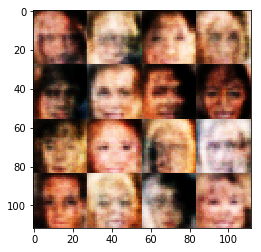

Epoch 1/1... Discriminator Loss: 0.4677... Generator Loss: 2.4927
Epoch 1/1... Discriminator Loss: 0.3470... Generator Loss: 5.8974
Epoch 1/1... Discriminator Loss: 0.3907... Generator Loss: 4.8472
Epoch 1/1... Discriminator Loss: 0.3762... Generator Loss: 4.3383
Epoch 1/1... Discriminator Loss: 0.3816... Generator Loss: 4.4291
Epoch 1/1... Discriminator Loss: 0.4300... Generator Loss: 2.8893
Epoch 1/1... Discriminator Loss: 0.3853... Generator Loss: 3.7703
Epoch 1/1... Discriminator Loss: 0.3514... Generator Loss: 5.1049
Epoch 1/1... Discriminator Loss: 0.3446... Generator Loss: 6.3376
Epoch 1/1... Discriminator Loss: 0.3859... Generator Loss: 3.5352


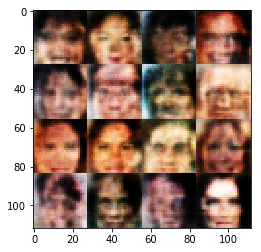

Epoch 1/1... Discriminator Loss: 0.3880... Generator Loss: 3.3648
Epoch 1/1... Discriminator Loss: 0.3977... Generator Loss: 3.0945
Epoch 1/1... Discriminator Loss: 0.4267... Generator Loss: 2.7676
Epoch 1/1... Discriminator Loss: 0.3618... Generator Loss: 4.6856
Epoch 1/1... Discriminator Loss: 0.4798... Generator Loss: 2.2432
Epoch 1/1... Discriminator Loss: 0.3823... Generator Loss: 3.7091
Epoch 1/1... Discriminator Loss: 0.3735... Generator Loss: 3.8376
Epoch 1/1... Discriminator Loss: 0.4325... Generator Loss: 2.6605
Epoch 1/1... Discriminator Loss: 0.4305... Generator Loss: 2.6863
Epoch 1/1... Discriminator Loss: 0.3951... Generator Loss: 3.3235


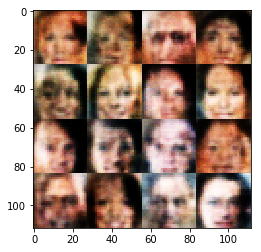

Epoch 1/1... Discriminator Loss: 0.3720... Generator Loss: 4.0127
Epoch 1/1... Discriminator Loss: 0.5495... Generator Loss: 1.9090
Epoch 1/1... Discriminator Loss: 0.4052... Generator Loss: 3.2293
Epoch 1/1... Discriminator Loss: 0.3975... Generator Loss: 3.2259
Epoch 1/1... Discriminator Loss: 0.4774... Generator Loss: 2.3242
Epoch 1/1... Discriminator Loss: 0.3606... Generator Loss: 6.7165
Epoch 1/1... Discriminator Loss: 0.3880... Generator Loss: 5.8937
Epoch 1/1... Discriminator Loss: 0.4771... Generator Loss: 2.3487
Epoch 1/1... Discriminator Loss: 0.3666... Generator Loss: 4.1437
Epoch 1/1... Discriminator Loss: 0.3547... Generator Loss: 4.7200


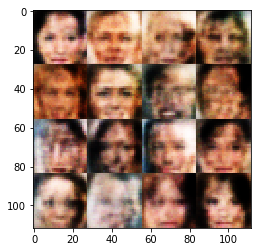

Epoch 1/1... Discriminator Loss: 0.3716... Generator Loss: 4.1067
Epoch 1/1... Discriminator Loss: 0.3721... Generator Loss: 4.2023
Epoch 1/1... Discriminator Loss: 0.3567... Generator Loss: 5.0819
Epoch 1/1... Discriminator Loss: 0.3795... Generator Loss: 3.6136
Epoch 1/1... Discriminator Loss: 0.4068... Generator Loss: 3.0623
Epoch 1/1... Discriminator Loss: 0.3947... Generator Loss: 3.2552
Epoch 1/1... Discriminator Loss: 0.3596... Generator Loss: 4.5784
Epoch 1/1... Discriminator Loss: 0.3619... Generator Loss: 5.7616
Epoch 1/1... Discriminator Loss: 0.3638... Generator Loss: 4.7689
Epoch 1/1... Discriminator Loss: 0.4641... Generator Loss: 2.4411


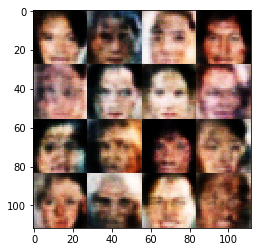

Epoch 1/1... Discriminator Loss: 0.4324... Generator Loss: 2.9434
Epoch 1/1... Discriminator Loss: 0.3662... Generator Loss: 4.6323
Epoch 1/1... Discriminator Loss: 0.3663... Generator Loss: 5.5077
Epoch 1/1... Discriminator Loss: 0.3970... Generator Loss: 3.4635
Epoch 1/1... Discriminator Loss: 0.3868... Generator Loss: 3.5801
Epoch 1/1... Discriminator Loss: 0.3638... Generator Loss: 5.1960
Epoch 1/1... Discriminator Loss: 0.3735... Generator Loss: 4.7764
Epoch 1/1... Discriminator Loss: 0.3852... Generator Loss: 4.1378
Epoch 1/1... Discriminator Loss: 0.3591... Generator Loss: 5.1184
Epoch 1/1... Discriminator Loss: 0.3552... Generator Loss: 5.2983


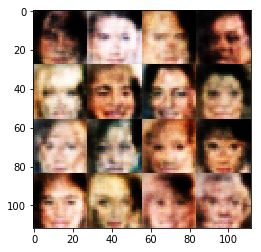

Epoch 1/1... Discriminator Loss: 0.3626... Generator Loss: 4.9589
Epoch 1/1... Discriminator Loss: 0.3872... Generator Loss: 3.6043
Epoch 1/1... Discriminator Loss: 0.3917... Generator Loss: 3.6407
Epoch 1/1... Discriminator Loss: 0.4010... Generator Loss: 4.4048
Epoch 1/1... Discriminator Loss: 0.4205... Generator Loss: 3.7089
Epoch 1/1... Discriminator Loss: 0.3516... Generator Loss: 4.7561
Epoch 1/1... Discriminator Loss: 0.3768... Generator Loss: 3.7477
Epoch 1/1... Discriminator Loss: 0.3939... Generator Loss: 3.5471
Epoch 1/1... Discriminator Loss: 0.3588... Generator Loss: 4.5491
Epoch 1/1... Discriminator Loss: 0.3895... Generator Loss: 3.6117


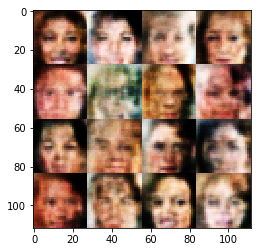

Epoch 1/1... Discriminator Loss: 0.4187... Generator Loss: 2.7856
Epoch 1/1... Discriminator Loss: 0.4186... Generator Loss: 3.0122
Epoch 1/1... Discriminator Loss: 0.3675... Generator Loss: 4.8443
Epoch 1/1... Discriminator Loss: 0.3527... Generator Loss: 5.6458
Epoch 1/1... Discriminator Loss: 0.3918... Generator Loss: 4.0837
Epoch 1/1... Discriminator Loss: 0.3927... Generator Loss: 3.3705
Epoch 1/1... Discriminator Loss: 0.4016... Generator Loss: 3.7182
Epoch 1/1... Discriminator Loss: 0.3928... Generator Loss: 4.3173
Epoch 1/1... Discriminator Loss: 0.3789... Generator Loss: 3.7106
Epoch 1/1... Discriminator Loss: 0.3871... Generator Loss: 4.0477


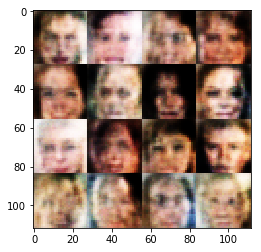

Epoch 1/1... Discriminator Loss: 0.3693... Generator Loss: 3.9984
Epoch 1/1... Discriminator Loss: 0.3600... Generator Loss: 4.4903
Epoch 1/1... Discriminator Loss: 0.3664... Generator Loss: 5.3315
Epoch 1/1... Discriminator Loss: 0.3644... Generator Loss: 4.0630
Epoch 1/1... Discriminator Loss: 0.3750... Generator Loss: 4.5215
Epoch 1/1... Discriminator Loss: 0.3544... Generator Loss: 4.7414
Epoch 1/1... Discriminator Loss: 0.3776... Generator Loss: 3.6847


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.